# DSHARP absorption-only opacities
| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  05/12/2024          |
| Updated |  05/12/2024          |

See [Desmos](https://www.desmos.com/) for interactive plots of 
- [$T = P/\rho$](https://www.desmos.com/calculator/ptyevuziu7)
- [$\rho_\mathrm{mid}$](https://www.desmos.com/calculator/ubtsqj1ltb)
- [$\rho(\theta)$](https://www.desmos.com/calculator/marlugmhhr)

In code units,
\begin{align*}
  T(r, \theta) &= \frac{P(r, \theta)}{\rho} = \frac{P_0}{\rho_0}\left(\frac{r\sin\theta}{r_0}\right)^{-1/2}, \\
  \rho_\mathrm{mid}(r) &= \frac{\rho_0\left(\frac{r + r_0}{r_0}\right)^{-9/4}}{1 + \exp\left[-\mathrm{e}^\mathrm{e}\left(\frac{r - r_0}{r_0}\right)\right]}, \\
  \rho(r, \theta) &= \rho_\mathrm{mid}\exp\left[\frac{GMr}{P}\left(\frac{1}{\sqrt{r^2\sin^2\theta + r^2\cos^2\theta}} - \frac{1}{r\sin\theta}\right)\right], \\
                  &= \rho_\mathrm{mid}\exp\left[\frac{GM}{P}\left(1 - \frac{1}{\sin\theta}\right)\right]. \\
\end{align*}

## DSHARP Opacities

- Birnstiel et al. ([2018](https://ui.adsabs.harvard.edu/abs/2018ApJ...869L..45B/abstract))
- (From Shangjia Zhang)
  - 30% water
  - Carbon?

Reading dustkappa_dsharp.inp


[None,
 None,
 Text(0.5, 0, '$\\mathrm{\\lambda}$ ($\\mathrm{\\mu}$m)'),
 Text(0, 0.5, '$\\kappa_\\nu^\\mathrm{abs}$ (cm$^2$ g$^{-1}$)'),
 Text(0.5, 1.0, 'DSHARP ($a_\\mathrm{max}=1\\,\\mathrm{\\mu m}, q=3.5$)')]

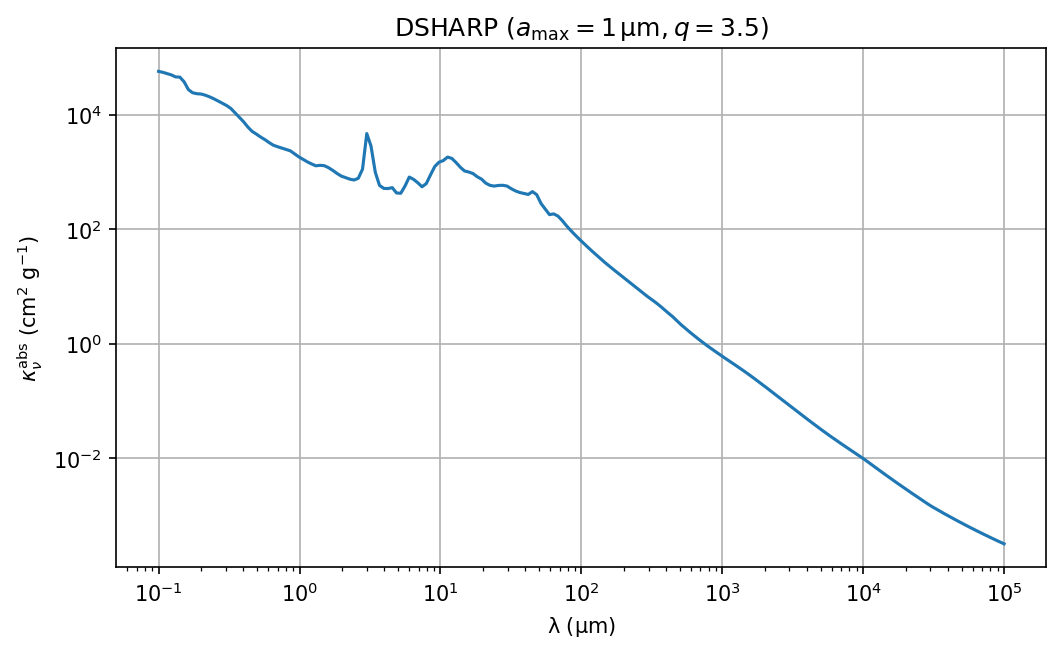

In [12]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import analyze # execute cell twice
from radmc3dPy.natconst import *

# Plot absorption coefficient as a function of wavelength
opac   = analyze.readOpac(ext=['dsharp']) #https://www.ita.uni-heidelberg.de/~dullemond/software/radmc-3d/manual_rmcpy/radmc3dPy.html?highlight=radmc3ddustopac#radmc3dPy.dustopac.radmc3dDustOpac
figsize = (4, 3)
figsize = (8, 4.5)
fig, ax = plt.subplots(figsize=figsize, dpi=150)

ax.plot(opac.wav[0], opac.kabs[0])
# ax.plot(opac.wav[0], opac.ksca[0])
ax.grid()
ax.minorticks_on()
ax.set(xscale='log', yscale='log', xlabel=r'$\mathrm{\lambda}$ ($\mathrm{\mu}$m)',
       ylabel=r'$\kappa_\nu^\mathrm{abs}$ (cm$^2$ g$^{-1}$)',
       title=r'DSHARP ($a_\mathrm{max}=1\,\mathrm{\mu m}, q=3.5$)')

## Temperature Profiles

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat


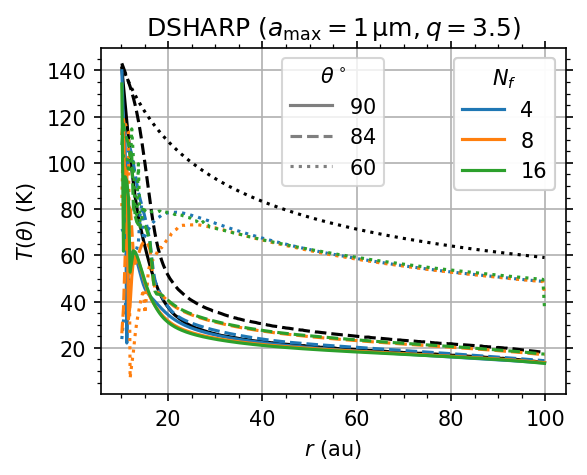

In [8]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Conversions
rad2deg = 180/np.pi # [deg]

# Set up plots
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
tab_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# lss = ['solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5))]
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 84, 60]
c_solns, ls_thetas = [], []

# Read and plot RADMC-3D solutions
data = analyze.readData(ddens=True, dtemp=True)
dtheta = (data.grid.yi[-1] - data.grid.yi[0])/data.grid.ny

for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    ax.plot(data.grid.x/natconst.au, data.dusttemp[:,j,0,0], 'black',
            ls=lss[th])
    ls_thetas.append(ax.plot([], [], color='tab:gray', ls=lss[th],
                     label=rf'${theta_deg}$')[0])

# Read and plot Athena++ solutions
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'
problem_id = 'dsharp'
runs = ['nfreq4', 'nfreq8', 'nfreq16']

for i, run in enumerate(runs):
    path = f'{base}/dsharp_abs-cfl_rad0.5/{run}'
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
    dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
             /athinput['mesh']['nx2']
    L_0 = athinput['radiation']['length_unit']
    T_0 = athinput['radiation']['T_unit']
    athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
    T_field = athdf['press'][0]/athdf['rho'][0]*T_0
    c_solns.append(ax.plot([], [], tab_colors[i], label=f'{run[5:]}')[0])

    for th, theta_deg in enumerate(theta_degs):
        j = int(theta_deg/rad2deg/dtheta)
        ax.plot(athdf['x1v']*L_0/natconst.au, T_field[j, :], tab_colors[i],
                ls=lss[th])

# Plot ghost points for colorless line style and add legends
ls_legend = plt.legend(title=r'$\theta^\circ$', handles=ls_thetas,
                       loc='upper center')
color_legend = plt.legend(title=r'$N_f$', handles=c_solns, loc='upper right')
ax.add_artist(ls_legend)
ax.add_artist(color_legend)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(xlabel=r'$r$ (au)', ylabel=r'$T(\theta)$ (K)',
       title=r'DSHARP ($a_\mathrm{max}=1\,\mathrm{\mu m}, q=3.5$)')
ax.tick_params(axis='both', which='both', top=True, right=True)

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat


/tmp/ipykernel_29842/740356010.py:58: UserWarning: The label '_child0' of <matplotlib.lines.Line2D object at 0x7fa926f6d0d0> starts with '_'. It is thus excluded from the legend.
  color_legend = plt.legend(title=r'$N_f$', handles=c_solns, loc='upper right')


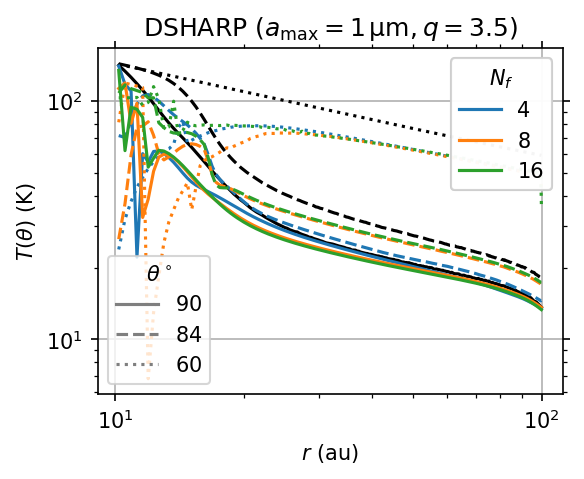

In [9]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# Conversions
rad2deg = 180/np.pi # [deg]

# Set up plots
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
tab_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple',
          'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# lss = ['solid', 'dashdot', 'dashed', 'dotted', (0, (1, 5))]
lss = ['solid', 'dashed', 'dotted']
theta_degs = [90, 84, 60]
c_solns, ls_thetas = [], []

# Read and plot RADMC-3D solutions
data = analyze.readData(ddens=True, dtemp=True)
dtheta = (data.grid.yi[-1] - data.grid.yi[0])/data.grid.ny
c_solns.append(ax.plot([], [], color='black')[0])

for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    ax.plot(data.grid.x/natconst.au, data.dusttemp[:,j,0,0], 'black',
            ls=lss[th])
    ls_thetas.append(ax.plot([], [], color='tab:gray', ls=lss[th],
                     label=rf'${theta_deg}$')[0])

# Read and plot Athena++ solutions
base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'
problem_id = 'const_opac_raytrace'
problem_id = 'dsharp'
runs = ['nfreq4', 'nfreq8', 'nfreq16']

for i, run in enumerate(runs):
    path = f'{base}/dsharp_abs-cfl_rad0.5/{run}'
    athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
    dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
             /athinput['mesh']['nx2']
    L_0 = athinput['radiation']['length_unit']
    T_0 = athinput['radiation']['T_unit']
    athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
    T_field = athdf['press'][0]/athdf['rho'][0]*T_0
    c_solns.append(ax.plot([], [], tab_colors[i], label=f'{run[5:]}')[0])

    for th, theta_deg in enumerate(theta_degs):
        j = int(theta_deg/rad2deg/dtheta)
        ax.plot(athdf['x1v']*L_0/natconst.au, T_field[j, :], tab_colors[i],
                ls=lss[th])

# Plot ghost points for colorless line style and add legends
ls_legend = plt.legend(title=r'$\theta^\circ$', handles=ls_thetas,
                       loc='lower left')
color_legend = plt.legend(title=r'$N_f$', handles=c_solns, loc='upper right')
ax.add_artist(ls_legend)
ax.add_artist(color_legend)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(xscale='log', yscale='log', xlabel=r'$r$ (au)', ylabel=r'$T(\theta)$ (K)',
       title=r'DSHARP ($a_\mathrm{max}=1\,\mathrm{\mu m}, q=3.5$)')
ax.tick_params(axis='both', which='both', top=True, right=True)

## Flux Profiles

Reading amr_grid.inp
Reading wavelength_micron.inp
Reading dust_density.inp
Reading dust_temperature.dat
Reading mean_intensity.out


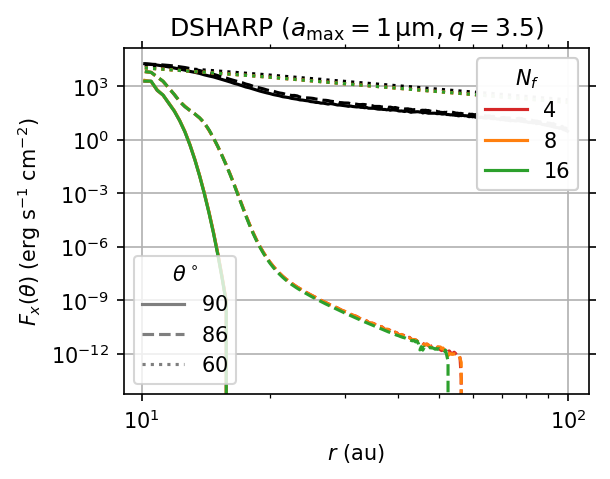

In [10]:
#===============================================================================
import matplotlib.pyplot as plt
import numpy as np
from radmc3dPy import *
import sys
sys.path.insert(0, '/home/stanley/github/PrincetonUniversity/athena/vis/python')
import athena_read

# constants
arad = 7.565733250033928e-15
c_speed = 2.99792458e10 # // speed of light

base = '/home/stanley/github/sabaronett/rad-hydro/athena/dev/yanfeij'
problem_id = 'dsharp'
fig, ax = plt.subplots(figsize=(4, 3), dpi=150)
tab_colors = ['tab:red', 'tab:orange', 'tab:green', 'tab:blue', 'tab:purple',
              'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
theta_degs = [90, 86, 60]
lss = ['solid', 'dashed', 'dotted']
c_solns, ls_thetas = [], []
runs = ['nfreq4', 'nfreq8', 'nfreq16']

# Compute flux from frequency-integrated mean intensities and optical depth
data = analyze.readData(ddens=True, dtemp=True, mint=True)
F = 4*np.pi*np.abs(np.trapz(data.meanint, data.freq, axis=-1))

for th, theta_deg in enumerate(theta_degs):
    # Plot analytic solution
    j = int(theta_deg/rad2deg/dtheta)
    ax.plot(data.grid.x/natconst.au, F[:,j,0], color='black', ls=lss[th])
    ls_thetas.append(ax.plot([], [], color='tab:gray', ls=lss[th],
                     label=rf'${theta_deg}$')[0])

# c_solns.append(ax.plot([], [], color='black', label='Analytic')[0])

# Read and plot explicit RT Athena++ solutions
for i, run in enumerate(runs):
  path = f'{base}/dsharp_abs-cfl_rad0.5/{run}'
  athinput = athena_read.athinput(f'{path}/athinput.{problem_id}')
  dtheta = (athinput['mesh']['x2max'] - athinput['mesh']['x2min'])\
           /athinput['mesh']['nx2']
  L_0 = athinput['radiation']['length_unit']
  T_0 = athinput['radiation']['T_unit']
  athdf = athena_read.athdf(f'{path}/athdf/{problem_id}.out1.00001.athdf')
  key = 'Fr01'
  if 'n_frequency' in athinput['radiation']:
    N_f = athinput['radiation']['n_frequency']
    key = f'Fr0_{N_f-1}_1'
  Fx_field = athdf[key][0]*c_speed*arad*T_0**4

  for th, theta_deg in enumerate(theta_degs):
    j = int(theta_deg/rad2deg/dtheta)
    ax.plot(athdf['x1v']*L_0/natconst.au, Fx_field[j, :], color=tab_colors[i],
            ls=lss[th])
  
  c_solns.append(ax.plot([], [], color=tab_colors[i], label=run[5:])[0])


# Plot ghost points for colorless line style and add legends
ls_legend = plt.legend(title=r'$\theta^\circ$', handles=ls_thetas,
                       loc='lower left')
color_legend = plt.legend(title=r'$N_f$', handles=c_solns, loc='upper right')
ax.add_artist(ls_legend)
ax.add_artist(color_legend)

# Format (sub)plots
ax.grid()
ax.minorticks_on()
ax.set(xscale='log', yscale='log', xlabel=r'$r$ (au)',
       ylabel=r'$F_x(\theta)$ (erg s$^{-1}$ cm$^{-2}$)',
       title=r'DSHARP ($a_\mathrm{max}=1\,\mathrm{\mu m}, q=3.5$)')
ax.tick_params(axis='both', which='both', top=True, right=True)
# plt.savefig('filename.pdf', bbox_inches='tight', pad_inches=0.01)